# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from random import sample
import cv2

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator



import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Variable

In [2]:
if '.DS_Store' in os.listdir("data/"):
    os.remove("data/.DS_Store")

In [3]:
DATA_DIR = "data/"

HEIGHT = 224
WIDTH = 224
CHANNELS = 3

EPOCHS = 5

LABEL = os.listdir(DATA_DIR)
NUM_CATEGORIES = len(LABEL)


In [4]:
LABEL

['mask_weared_incorrect', 'with_mask', 'without_mask']

# Data

In [5]:
images = []
label = []

for folder in LABEL:
    fol = os.listdir(DATA_DIR + '/' + folder)
    print(len(fol))
    images += fol
    label += [folder] * len(fol)

2994
2994
2994


In [6]:
len(images), len(label)

(8982, 8982)

In [7]:
data = pd.DataFrame({"Image":images, "Label": label})
data.head()

,Image,Label
0,348.png,mask_weared_incorrect
1,1804.png,mask_weared_incorrect
2,1810.png,mask_weared_incorrect
3,1186.png,mask_weared_incorrect
4,412.png,mask_weared_incorrect


In [8]:
data["Image"] = data["Label"] +"/"+ data["Image"]

In [9]:
data.head()

,Image,Label
0,mask_weared_incorrect/348.png,mask_weared_incorrect
1,mask_weared_incorrect/1804.png,mask_weared_incorrect
2,mask_weared_incorrect/1810.png,mask_weared_incorrect
3,mask_weared_incorrect/1186.png,mask_weared_incorrect
4,mask_weared_incorrect/412.png,mask_weared_incorrect


# EDA

(array([0, 1, 2]),
 [Text(0, 0, 'mask_weared_incorrect'),
  Text(1, 0, 'with_mask'),
  Text(2, 0, 'without_mask')])

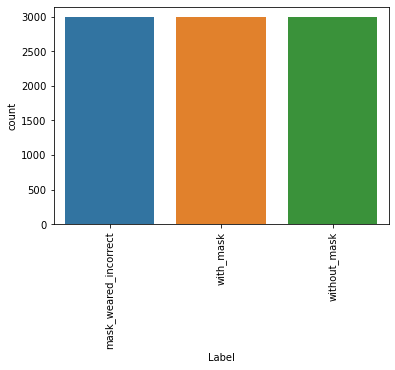

In [10]:
sns.countplot(x=data["Label"])
plt.xticks(rotation=90)

In [11]:
def plot_images(label, total_images=6):
    plot_list = data[data['Label'] == label].sample(total_images)["Image"].tolist()
    size = int(np.sqrt(total_images))
    if size*size < total_images:
        size += 1
    
    plt.figure(figsize=(15,15))
    
    for i in range(total_images):
        plt.subplot(size, size, i+1)
        image = Image.open(str(DATA_DIR + "/" +plot_list[i]))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis("off")
        
    plt.show()

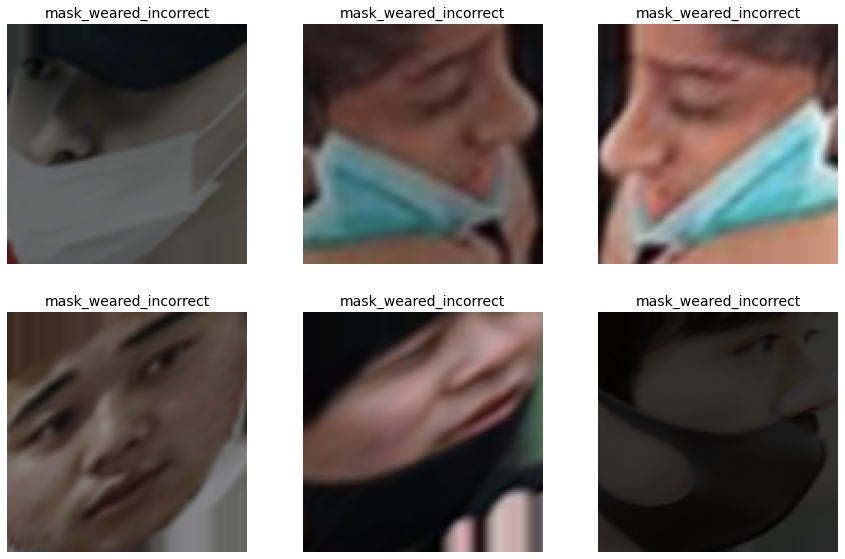

In [12]:
plot_images('mask_weared_incorrect')

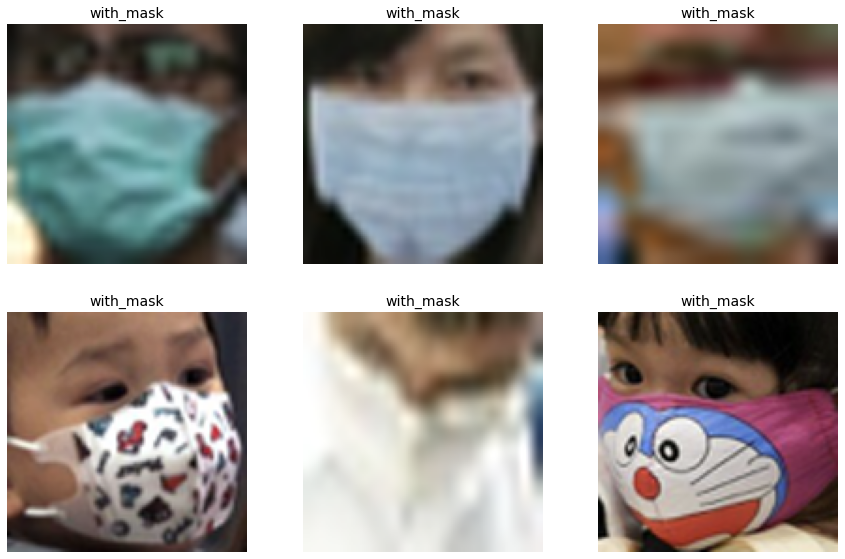

In [13]:
plot_images('with_mask')

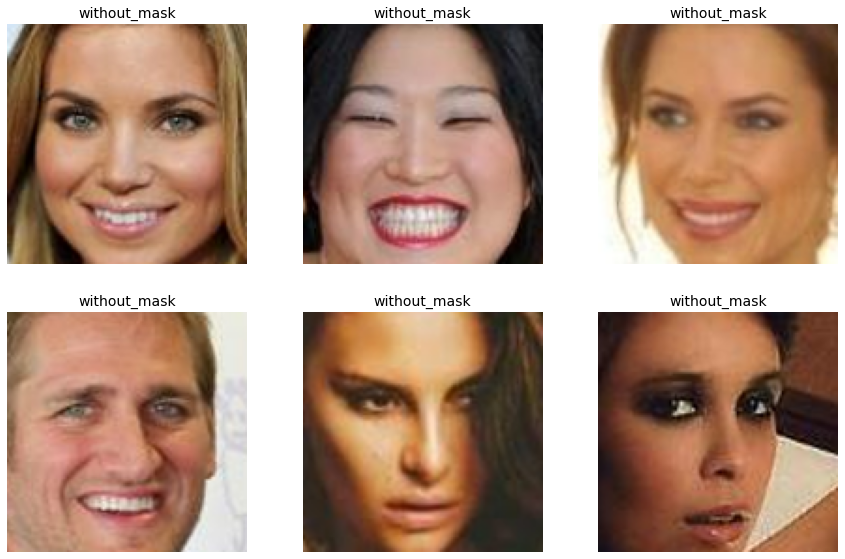

In [14]:
plot_images('without_mask')

# Split Datasets

In [15]:
data = data.sample(frac=1)

In [16]:
X_train = data[:8000]
X_test = data[8000:]

In [17]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   validation_split=0.25,
                                   shear_range=0.2)

train_data = train_datagen.flow_from_dataframe(dataframe=X_train,
                                               x_col="Image",
                                               y_col="Label",
                                               directory=DATA_DIR,
                                               target_size=(HEIGHT,WIDTH),
                                               class_mode='categorical',
                                               shuffle=True,
                                               batch_size=32,
                                               subset='training')

val_data = train_datagen.flow_from_dataframe(dataframe=X_train,
                                               x_col="Image",
                                               y_col="Label",
                                               directory=DATA_DIR,
                                               target_size=(HEIGHT,WIDTH),
                                               class_mode='categorical',
                                               shuffle=True,
                                               batch_size=32,
                                               subset='validation')


test_datagen = ImageDataGenerator(rescale=1.0/255)

test_data = train_datagen.flow_from_dataframe(dataframe=X_test,
                                              x_col="Image",
                                              y_col="Label",
                                              directory=DATA_DIR,
                                              target_size=(HEIGHT,WIDTH),
                                              class_mode='categorical',
                                              batch_size=32)

Found 6000 validated image filenames belonging to 3 classes.
Found 2000 validated image filenames belonging to 3 classes.
Found 982 validated image filenames belonging to 3 classes.


# Model 

In [18]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(HEIGHT,WIDTH,3))

for layer in vgg16.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.summary()

2022-03-04 14:04:20.388439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [20]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data)

Epoch 1/5
188/188 [==============================] - 1546s 8s/step - loss: 0.3380 - accuracy: 0.8790 - val_loss: 0.1891 - val_accuracy: 0.9385
Epoch 2/5
188/188 [==============================] - 1277s 7s/step - loss: 0.1510 - accuracy: 0.9477 - val_loss: 0.1287 - val_accuracy: 0.9600
Epoch 3/5
188/188 [==============================] - 1290s 7s/step - loss: 0.1145 - accuracy: 0.9593 - val_loss: 0.1144 - val_accuracy: 0.9675
Epoch 4/5
188/188 [==============================] - 1267s 7s/step - loss: 0.0950 - accuracy: 0.9693 - val_loss: 0.1114 - val_accuracy: 0.9570
Epoch 5/5
188/188 [==============================] - 1382s 7s/step - loss: 0.0880 - accuracy: 0.9698 - val_loss: 0.0905 - val_accuracy: 0.9695


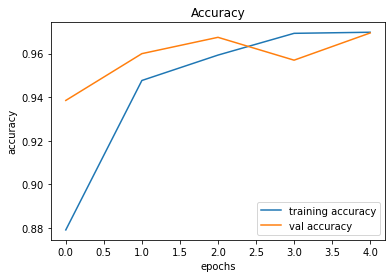

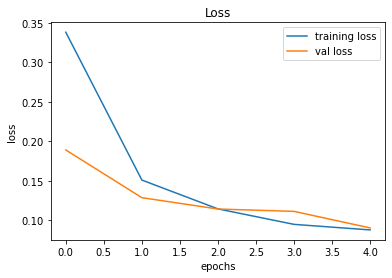

In [21]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
print ('saving the weights')
model.save('mask.h5')
print ('Save Model')

saving the weights
Save Model


In [23]:
from tensorflow import keras
model = keras.models.load_model('mask.h5')

In [24]:
y_pred = model.evaluate(test_data)
y_pred

31/31 [==============================] - 179s 6s/step - loss: 0.1046 - accuracy: 0.9613


[0.10455083847045898, 0.9613034725189209]

In [25]:
def predict(img):
    pred = model.predict(img/255.0)
    pred = np.argmax(pred)
    return LABEL[pred]

In [26]:
def plot_images_with_prediction(cnt=6):
    plot_list = data.sample(cnt)["Image"].tolist()
    size = int(np.sqrt(cnt))
    if size*size < cnt:
        size += 1
    
    plt.figure(figsize=(15,15))
    
    for i in range(cnt):
        plt.subplot(size, size, i+1)
        image = cv2.imread(str(DATA_DIR + "/" +plot_list[i]))
        image = cv2.resize(image,(HEIGHT,WIDTH))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        image = np.reshape(image,[1,HEIGHT,WIDTH,3])
        pred = predict(image)
        label = plot_list[i].split("/")[0]
        title = "Actual: "+ str(label) +"\nPredicted: "+ str(pred)
        plt.title(title, fontsize=8)
        plt.axis("off")
        
    plt.show()

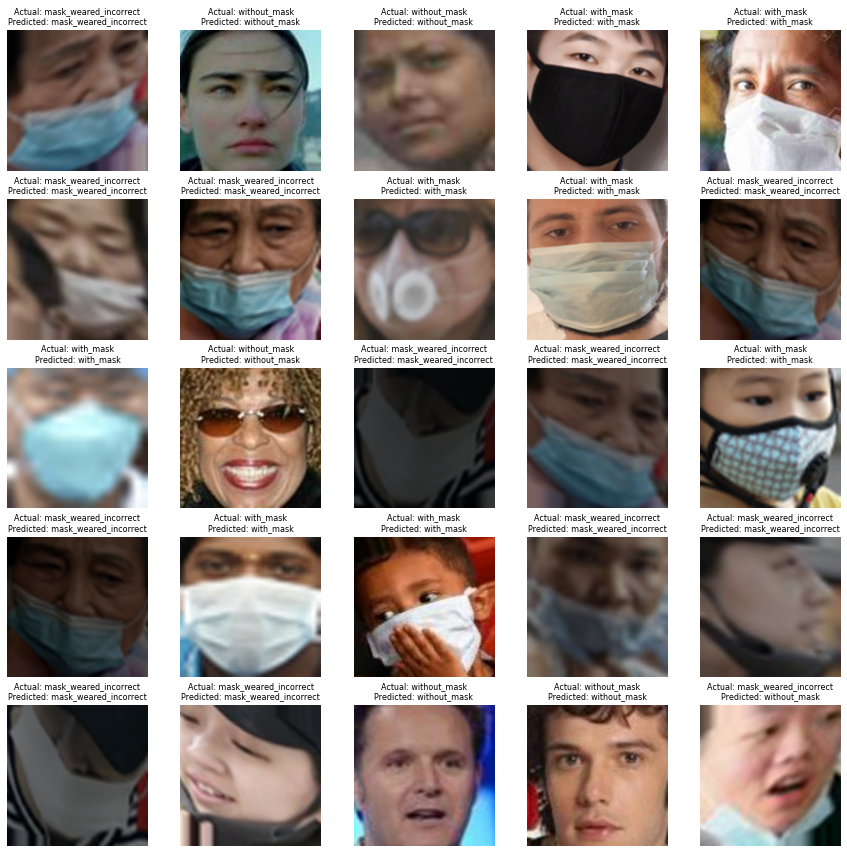

In [28]:
plot_images_with_prediction(cnt=25)